# ДЗ-1, Настя Чижикова 

In [ ]:
! pip install pandas --upgrade

In [ ]:
! pip install langdetect

In [2]:
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import spacy
import string

nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(set(stopwords.words('english')))
stop_words.remove('not')
stop_words.remove('very')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
data = pd.read_csv('Shoes_Data.csv')

In [4]:
data.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


## Задание 1 (задача регрессии)

In [5]:
def clean_price(price: str) -> float:
    return float(price[1:])

In [6]:
def preprocess(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    new_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    
    return ' '.join(new_tokens)

Приводим колонку price к числовому формату, препроцессим тексты описания (убираем всё, что не слова и избавляемся от стоп-слов)

In [7]:
df_1 = pd.DataFrame()
df_1['price'] = data['price'].apply(clean_price)
df_1['description'] = data['product_description']
#df_1['full_description'] = data['title'] + ' ' + data['product_description']

In [8]:
df_1['description'] = df_1.description.apply(preprocess)

Есть ли в данных пропуски

In [9]:
df_1.isna().sum()

price          0
description    0
dtype: int64

После препроцессинга некоторые тексты оказались пустыми (а некоторые были пустыми и до) - убираем их

In [10]:
df_1 = df_1[(df_1.description != ' ') & (df_1.description != '')]

И избавляемся от дублей

In [11]:
df_1 = df_1.drop_duplicates(subset=['description'])
df_1.reset_index(inplace=True, drop=True)

In [12]:
df_1.head()

,price,description
0,279.0,elevate style classy pair running shoe house c...
1,479.0,product excellent pick ensures easy maintenance
2,430.0,flaunt stylish unique red casual shoes per lat...
3,499.0,robbie jones shoes designed keeping mind durab...
4,499.0,sparx spectacular range footwear house relaxo ...


Убираем все данные, где описание не не английском

In [13]:
df_1['language'] = df_1.description.apply(detect)
df_1 = df_1[df_1.language == 'en']
df_1.reset_index()
df_1.head()

,price,description,language
0,279.0,elevate style classy pair running shoe house c...,en
2,430.0,flaunt stylish unique red casual shoes per lat...,en
3,499.0,robbie jones shoes designed keeping mind durab...,en
4,499.0,sparx spectacular range footwear house relaxo ...,en
5,449.0,casual shoes boys mens white colour,en


Посмотрим распределение целевой перменной - видим, что средняя цена составляет примерно 1500, при этом достаточно много выбросов, максимальное значение - 8000

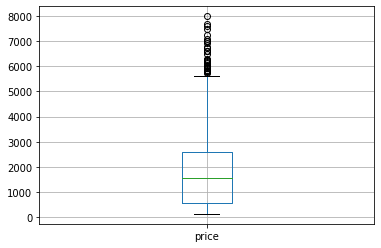

In [14]:
df_1.boxplot(column=['price'])

Посмотрим распределение длины описания - видим, что в среднем после препроцессинга длина описания небольшая (до 50 токенов), но встречаются и длинные

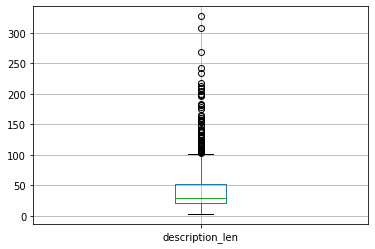

In [15]:
def get_length(text: str) -> int:
    return len(word_tokenize(text))

df_1['description_len'] = df_1.description.apply(get_length)
df_1.boxplot(column=['description_len'])

Финальное количество данных

In [16]:
df_1.shape

(672, 4)

### Гридсерч по моделям и векторайзерам

In [17]:
y = df_1.price.values
X = df_1.description.values

data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# baseline
vectorizer = CountVectorizer(min_df=5)
X_train = vectorizer.fit_transform(data_train)

X_test = vectorizer.transform(data_test)
print('X and y_train shapes: ', X_train.shape, y_train.shape)

linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, y_pred))

X and y_train shapes:  (537, 805) (537,)
MAE:  3132.383334058674


In [20]:
from sklearn.pipeline import Pipeline


dt_pipe = Pipeline([
 ('tvec', TfidfVectorizer(min_df=5)),
 ('dt', DecisionTreeRegressor(random_state=42))
])

rid_pipe = Pipeline([
 ('tvec', TfidfVectorizer(min_df=5)),
 ('rid', Ridge(random_state=42))
])

las_pipe = Pipeline([
 ('tvec', TfidfVectorizer(min_df=5)),
 ('las', Lasso(random_state=42))
])


dt_pipe_2 = Pipeline([
 ('cvec', CountVectorizer(min_df=5)),
 ('dt', DecisionTreeRegressor(random_state=42))
])

rid_pipe_2 = Pipeline([
 ('cvec', CountVectorizer(min_df=5)),
 ('rid', Ridge(random_state=42))
])

las_pipe_2 = Pipeline([
 ('cvec', CountVectorizer(min_df=5)),
 ('las', Lasso(random_state=42))
])


dt_params = {
 'dt__max_depth':[5, 10, 50, 100, 500, 1000, None],
 'dt__min_samples_split': [2, 4, 6, 8],
 'dt__max_features': [None, 'auto', 'sqrt', 'log2'],
}

rid_params = {
 'rid__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

las_params = {
 'las__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [21]:
from sklearn.model_selection import GridSearchCV

dt_gs = GridSearchCV(dt_pipe, param_grid=dt_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)
rid_gs = GridSearchCV(rid_pipe, param_grid=rid_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)
las_gs = GridSearchCV(las_pipe, param_grid=las_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)

dt_gs_2 = GridSearchCV(dt_pipe_2, param_grid=dt_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)
rid_gs_2 = GridSearchCV(rid_pipe_2, param_grid=rid_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)
las_gs_2 = GridSearchCV(las_pipe_2, param_grid=las_params, cv = 3, verbose = 0, n_jobs = -1, scoring='neg_mean_absolute_error').fit(data_train, y_train)

print('Best Score DecisionTree + TfIdf: %s' % dt_gs.best_score_)
print('Best DecisionTree + TfIdf Hyperparameters: %s' % dt_gs.best_params_)
print('\n')

print('Best Score Ridge + TfIdf: %s' % rid_gs.best_score_)
print('Best Ridge + TfIdf Hyperparameters: %s' % rid_gs.best_params_)
print('\n')

print('Best Score Lasso + TfIdf: %s' % las_gs.best_score_)
print('Best Lasso + TfIdf Hyperparameters: %s' % las_gs.best_params_)
print('\n')

print('Best Score DecisionTree + CountVect: %s' % dt_gs_2.best_score_)
print('Best DecisionTree + TfIdf Hyperparameters: %s' % dt_gs_2.best_params_)
print('\n')

print('Best Score Ridge + CountVect: %s' % rid_gs_2.best_score_)
print('Best Ridge + CountVect Hyperparameters: %s' % rid_gs_2.best_params_)
print('\n')

print('Best Score Lasso + CountVect: %s' % las_gs_2.best_score_)
print('Best Lasso + CountVect Hyperparameters: %s' % las_gs_2.best_params_)

Best Score DecisionTree + TfIdf: -1135.9106001013915
Best DecisionTree + TfIdf Hyperparameters: {'dt__max_depth': 10, 'dt__max_features': 'log2', 'dt__min_samples_split': 2}


Best Score Ridge + TfIdf: -878.7162733126974
Best Ridge + TfIdf Hyperparameters: {'rid__alpha': 1}


Best Score Lasso + TfIdf: -987.06968144682
Best Lasso + TfIdf Hyperparameters: {'las__alpha': 1}


Best Score DecisionTree + CountVect: -1070.4856605572243
Best DecisionTree + TfIdf Hyperparameters: {'dt__max_depth': 10, 'dt__max_features': None, 'dt__min_samples_split': 8}


Best Score Ridge + CountVect: -940.7031791761792
Best Ridge + CountVect Hyperparameters: {'rid__alpha': 100}


Best Score Lasso + CountVect: -1004.9855184822982
Best Lasso + CountVect Hyperparameters: {'las__alpha': 10}


Качество на тесте для лучшей модели гридсерча (векторизация TfIdf + Ridge)



In [25]:
rid_pipe.fit(data_train, y_train)
y_pred = rid_pipe.predict(data_test)

mean_absolute_error(y_test, y_pred)

891.2737861821257

In [ ]:
from matplotlib import pyplot


importance = reg_ridge.coef_
 
imp_df = pd.DataFrame()
imp_df['word'] = vectorizer.vocabulary_.keys()
imp_df['importance'] = importance

Анализ того, что получилось у модели

In [ ]:
imp_df['importance'] = imp_df.importance.apply(abs)
imp_df = imp_df.sort_values(by='importance', ascending=False)
imp_df.head(10)

,word,importance
479,whether,2978.459341
809,option,2453.509108
294,let,1853.231713
617,speed,1713.863880
59,flat,1686.229873
73,style,1575.331249
214,cushioned,1552.874132
650,suitable,1542.728643
731,pace,1536.995373
460,breaking,1519.993254


Не очень ясно, откуда здесь слова типа whether и let, но некоторые из них можно интерпретировать - на цену влияет "удобство", вид подошвы и тд.

Посмотрим, коррелирует ли ошибка с длиной описания

In [ ]:
test_df = pd.DataFrame()
test_df['description'] = data_test
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred
test_df['error'] = abs(test_df['y_true'] - test_df['y_pred'])
test_df['len'] = test_df.description.apply(get_length)

In [ ]:
test_df[['error', 'len']].corr()

,error,len
error,1.000000,0.017235
len,0.017235,1.000000


Корреляция приближена к нулю -  на наших данных корреляции длины описания и ошибки модели не нейдено

## Задание 2 (классификация)

Делим строки с несколькими отзывами на отдельные и приводим оценку к числовому виду

In [26]:
df_2 = pd.DataFrame()
df_2['reviews_rating'] = data.reviews_rating.str.split(pat="\|\| ")
df_2['reviews'] = data.reviews.str.split(pat="\|\| ")
df_2 = df_2.explode(['reviews_rating', 'reviews'], ignore_index=True)

In [27]:
df_2.reviews_rating.replace(to_replace=r' out of 5 stars', value='', regex=True, inplace=True)
df_2['reviews_rating'] = df_2.reviews_rating.astype(float).astype(int)

In [28]:
df_2.head()

,reviews_rating,reviews
0,1,Not happy with product
1,1,It's not as expected.
2,3,AVERAGE PRODUCT
3,3,Pic more beautiful
4,3,Got damage product. But quality is average for...


In [29]:
def detect_language(text) -> str:
    return detect(text)

def preprocess(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    new_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    
    return ' '.join(new_tokens)

Делаем препроцессинг, убираем не-английские отзывы, выкидываем пропущенные значения

In [30]:
df_2['reviews'] = df_2.reviews.apply(preprocess)
df_2.dropna()
df_2 = df_2[(df_2.reviews != ' ') & (df_2.reviews != '')]
df_2['lang'] = df_2.reviews.apply(detect)
df_2 = df_2[df_2.lang == 'en']

Количество данных

In [31]:
df_2.shape

(5345, 3)

Сбалансированы ли классы? - видим, что примеров на класс 5 в 10 раз больше, чем примеров на класс 2

In [32]:
df_2.reviews_rating.value_counts()

5    2639
1     996
4     939
3     476
2     295
Name: reviews_rating, dtype: int64

А как распределены длины отзывов? - после препроцессинга все достаточно короткие, состоящие из пары слов, есть только несколько выбросов с длиной больше 10

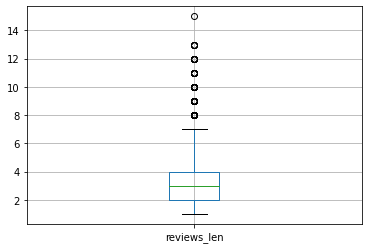

In [33]:
def get_length(text: str) -> int:
    return len(word_tokenize(text))

df_2['reviews_len'] = df_2.reviews.apply(get_length)
df_2.boxplot(column=['reviews_len'])

In [34]:
df_2.head()

,reviews_rating,reviews,lang,reviews_len
0,1,not happy product,en,3
1,1,not expected,en,2
5,2,bad product different listed,en,4
6,1,worst product,en,2
8,1,low quality makes pain heals sharp edges insid...,en,9


Гридсерч по разным моделям

In [35]:
y = df_2.reviews_rating.values
X = df_2.reviews.values

data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report

In [37]:
pipe_lr_c = Pipeline([('cvec', CountVectorizer()),
                    ('LR', LogisticRegression(random_state=42))])

pipe_dt_c = Pipeline([('cvec', CountVectorizer()),
                    ('DT', DecisionTreeClassifier(random_state=42))])

pipe_rf_c = Pipeline([('cvec', CountVectorizer()),
                    ('RF', RandomForestClassifier(random_state=42))])

pipe_svm_c = Pipeline([('cvec', CountVectorizer()),
                     ('SVM', svm.SVC(random_state=42))])


pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                    ('LR', LogisticRegression(random_state=42))])

pipe_dt = Pipeline([('tfidf', TfidfVectorizer()),
                    ('DT', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('RF', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('tfidf', TfidfVectorizer()),
                     ('SVM', svm.SVC(random_state=42))])


param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50, 100, 150]
learning_rates = [0.001, 0.1, 0.5]


lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]

svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]


In [38]:
lr_gs_c = GridSearchCV(pipe_lr_c, param_grid=lr_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
dt_gs_c = GridSearchCV(pipe_dt_c, param_grid=dt_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
rf_gs_c = GridSearchCV(pipe_rf_c, param_grid=rf_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
svm_gs_c = GridSearchCV(pipe_svm_c, param_grid=svm_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)

lr_gs = GridSearchCV(pipe_lr, param_grid=lr_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
dt_gs = GridSearchCV(pipe_dt, param_grid=dt_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
rf_gs = GridSearchCV(pipe_rf, param_grid=rf_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
svm_gs = GridSearchCV(pipe_svm, param_grid=svm_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)

In [39]:
print('Best Score LogReg + CountVect: %s' % lr_gs_c.best_score_)
print('Best LogReg Hyperparameters: %s' % lr_gs_c.best_params_)
print('\n')

print('Best Score DecisionTree + CountVect: %s' % dt_gs_c.best_score_)
print('Best DecisionTree Hyperparameters: %s' % dt_gs_c.best_params_)
print('\n')

print('Best Score RandomForest + CountVect: %s' % rf_gs_c.best_score_)
print('Best RandomForest Hyperparameters: %s' % rf_gs_c.best_params_)
print('\n')

print('Best Score SVM + CountVect: %s' % svm_gs_c.best_score_)
print('Best SVM Hyperparameters: %s' % svm_gs_c.best_params_)
print('\n')

print('Best Score LogReg + TfIdf: %s' % lr_gs.best_score_)
print('Best LogReg Hyperparameters: %s' % lr_gs.best_params_)
print('\n')

print('Best Score DecisionTree + TfIdf: %s' % dt_gs.best_score_)
print('Best DecisionTree Hyperparameters: %s' % dt_gs.best_params_)
print('\n')

print('Best Score RandomForest + TfIdf: %s' % rf_gs.best_score_)
print('Best RandomForest Hyperparameters: %s' % rf_gs.best_params_)
print('\n')

print('Best Score SVM + TfIdf: %s' % svm_gs.best_score_)
print('Best SVM Hyperparameters: %s' % svm_gs.best_params_)

Best Score LogReg + CountVect: 0.6456950698391607
Best LogReg Hyperparameters: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}


Best Score DecisionTree + CountVect: 0.583956267480295
Best DecisionTree Hyperparameters: {'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}


Best Score RandomForest + CountVect: 0.5018708529153647
Best RandomForest Hyperparameters: {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 3}


Best Score SVM + CountVect: 0.6681500619243294
Best SVM Hyperparameters: {'SVM__C': 2, 'SVM__kernel': 'rbf'}


Best Score LogReg + TfIdf: 0.6417205941454852
Best LogReg Hyperparameters: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}


Best Score DecisionTree + TfIdf: 0.5820857426408471
Best DecisionTree Hyperparameters: {'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 5}


Best Score RandomForest + TfIdf: 0.5011697546812333
B

Лучшей моделью оказался SVM, причем разные векторайзеры совсем незначительно отличаются по результату, теперь отдельно интересно посмотреть на лучшие параметры векторизатора

In [40]:
tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('SVM', svm.SVC(C=2, kernel='rbf', random_state=42))])

count_pipe = Pipeline([('count', CountVectorizer()),
                     ('SVM', svm.SVC(C=2, kernel='rbf', random_state=42))])

tfidf_param_grid = [{'tfidf__max_features':[None, 100, 2000, 10000],
                     'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                     'tfidf__min_df': [1, 5, 10]}]

count_param_grid = [{'count__max_features':[None, 100, 2000, 10000],
                     'count__ngram_range': [(1, 1), (1, 2), (2, 2)],
                     'count__min_df': [1, 5, 10]}]


tfidf_gs = GridSearchCV(tfidf_pipe, param_grid=tfidf_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)
count_gs = GridSearchCV(count_pipe, param_grid=count_param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='accuracy').fit(data_train, y_train)

print('Best Score TfIdf: %s' % tfidf_gs.best_score_)
print('Best Vect Hyperparameters: %s' % tfidf_gs.best_params_)

print('Best Score CountVect: %s' % count_gs.best_score_)
print('Best Vect Hyperparameters: %s' % count_gs.best_params_)

Best Score TfIdf: 0.6686175701057224
Best Vect Hyperparameters: {'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best Score CountVect: 0.6721265060735054
Best Vect Hyperparameters: {'count__max_features': None, 'count__min_df': 1, 'count__ngram_range': (1, 2)}


Качество на тесте лучшей модели (неожиданно победил Каунт Векторайзер)

In [42]:
pipe_svm = Pipeline([('cvec', CountVectorizer(max_features = None, min_df = 1, ngram_range = (1, 2))),
                     ('SVM', svm.SVC(C=2, kernel='rbf', random_state=42))]).fit(data_train, y_train)
y_pred = pipe_svm.predict(data_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.71      0.69       185
           2       0.64      0.15      0.24        62
           3       0.66      0.32      0.43        96
           4       0.74      0.26      0.39       213
           5       0.66      0.95      0.78       513

    accuracy                           0.67      1069
   macro avg       0.67      0.48      0.51      1069
weighted avg       0.68      0.67      0.62      1069



Видно, что самые высокие показатели качества модель достигает для самых многочисленных классов (1 и 5), на маленьких намного ниже полнота и ниже точность. Матрица ниже иллюстрирует это - самые больше показатели у true 1 - pred 1 и true 5 - pred 5. Интересно при этом, что часто 5 путается с 4 (что в целом ожидаемая ошибка, классы похожи), и неожиданно, что путаются классы 1 и 5.

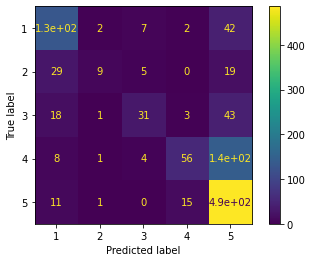

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svm, data_test, y_test)